In [20]:
import pandas as pd
import numpy as np
import os
import cv2
import itertools
#import imutils
import matplotlib.pyplot as plt
from keras.applications import VGG16
from sklearn.metrics import accuracy_score,confusion_matrix 
from sklearn.model_selection import train_test_split 
from keras.preprocessing import image
from keras.models import Model,Sequential
from keras.layers import Flatten,Dense,Dropout,Conv2D,MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop,Adam 
from keras.preprocessing.image import ImageDataGenerator
import shutil


In [2]:
BASE_DATASET_FOLDER = '/kaggle/input/files1/Malaria Cells'
VALIDATION_FOLDER = 'testing_set'
TRAIN_FOLDER = 'training_set'

In [3]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [25]:
IMAGE_SIZE = (100,100)
INPUT_SHAPE = (100,100, 3)
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 0.0001

In [26]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

In [27]:
train_generator = train_datagen.flow_from_directory(
        os.path.join(BASE_DATASET_FOLDER, TRAIN_FOLDER),
        target_size=IMAGE_SIZE,
        batch_size=TRAIN_BATCH_SIZE,
        class_mode='binary', 
        shuffle=True)

Found 27558 images belonging to 2 classes.


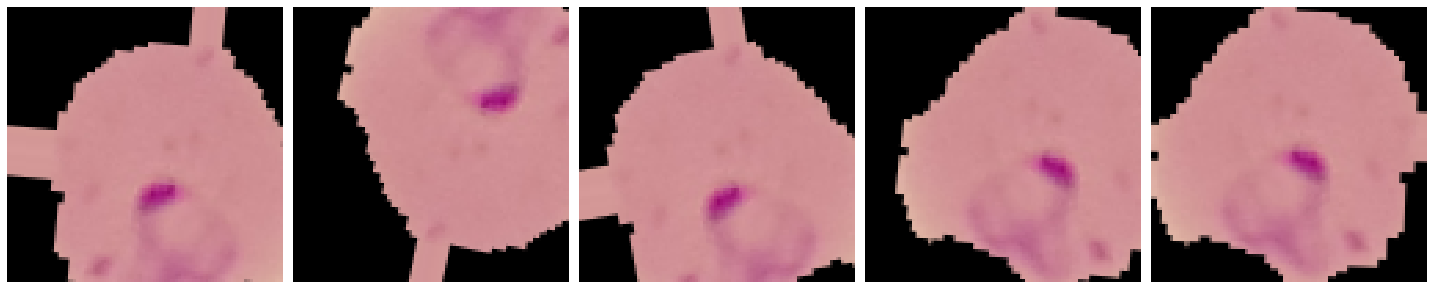

In [28]:
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [29]:
val_datagen=ImageDataGenerator(rescale=1./255)
val_generator=val_datagen.flow_from_directory(
    os.path.join(BASE_DATASET_FOLDER, VALIDATION_FOLDER),
    target_size=IMAGE_SIZE,
    class_mode='binary', 
    shuffle=False)

Found 15832 images belonging to 2 classes.


In [9]:
classes = {v: k for k, v in train_generator.class_indices.items()}
print(classes)

{0: 'Parasitized', 1: 'Uninfected'}


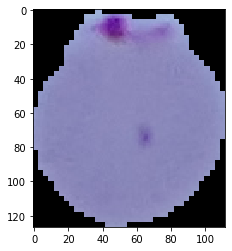

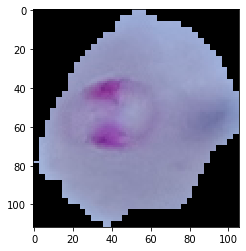

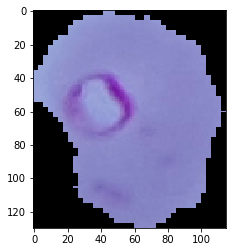

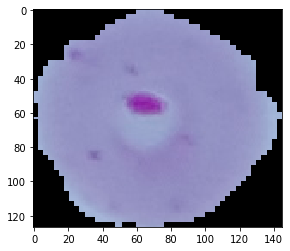

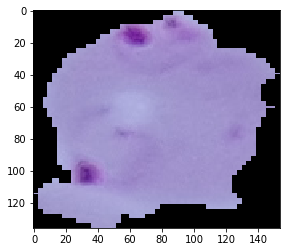

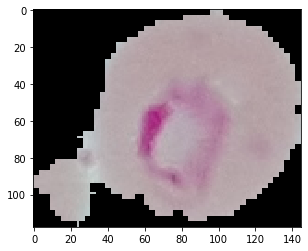

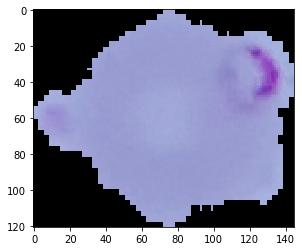

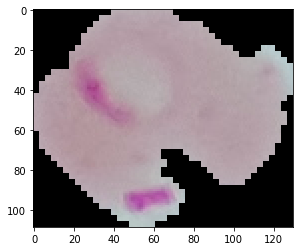

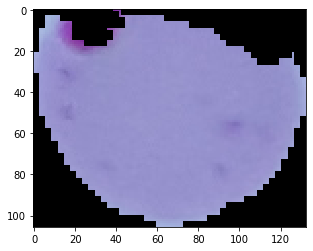

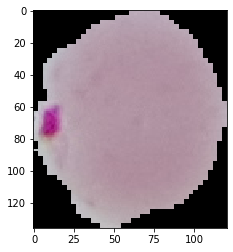

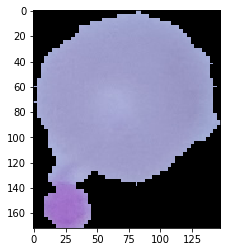

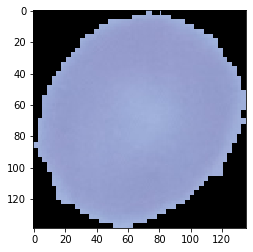

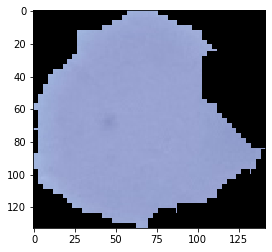

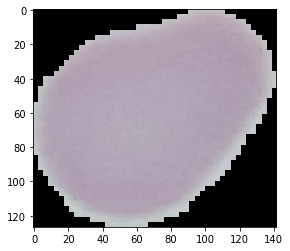

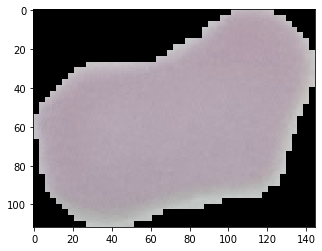

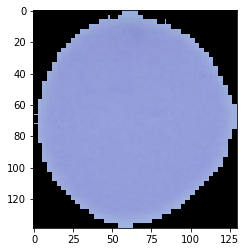

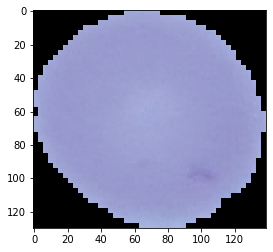

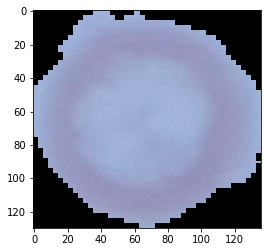

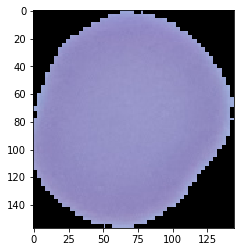

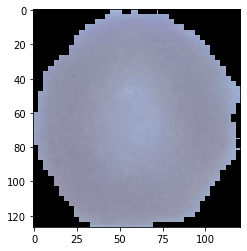

In [10]:
CATEGORIES = ["Parasitized","Uninfected"]
for category in CATEGORIES:  
    path = os.path.join('/kaggle/input/files1/Malaria Cells/training_set',category)  
    x=0
    for img in os.listdir(path): 
        x+=1
        img_array = cv2.imread(os.path.join(path,img))  
        plt.imshow(img_array)  #r graph it
        plt.show()  # display!
        if x==10 : 
            break

In [11]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)


58892288/58889256 [==============================] - 1s 0us/step


In [13]:
for layer in vgg_model.layers[:-4]:
    layer.trainable = False

In [36]:
model=Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(.2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(.2))
model.add(Conv2D(200, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(.2))
model.add(Conv2D(265, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 47, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 200)      

In [37]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

In [38]:
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

In [39]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=val_generator,
        validation_steps=val_generator.samples//val_generator.batch_size,
        callbacks=[es]
)

Epoch 1/100
430/430 [==============================] - 125s 291ms/step - loss: 0.6327 - acc: 0.6411 - val_loss: 0.5443 - val_acc: 0.8239
Epoch 2/100
430/430 [==============================] - 125s 292ms/step - loss: 0.3743 - acc: 0.8429 - val_loss: 0.4301 - val_acc: 0.9168
Epoch 3/100
430/430 [==============================] - 125s 291ms/step - loss: 0.2803 - acc: 0.8927 - val_loss: 0.2710 - val_acc: 0.9470
Epoch 4/100
430/430 [==============================] - 125s 291ms/step - loss: 0.2549 - acc: 0.9087 - val_loss: 0.1466 - val_acc: 0.9418
Epoch 5/100
430/430 [==============================] - 126s 292ms/step - loss: 0.2391 - acc: 0.9154 - val_loss: 0.1178 - val_acc: 0.9461
Epoch 6/100
430/430 [==============================] - 125s 290ms/step - loss: 0.2325 - acc: 0.9188 - val_loss: 0.0893 - val_acc: 0.9478
Epoch 7/100
430/430 [==============================] - 126s 293ms/step - loss: 0.2262 - acc: 0.9209 - val_loss: 0.3226 - val_acc: 0.9499
Epoch 8/100
430/430 [====================

Text(0.5, 1.0, 'Accuracy Curves')

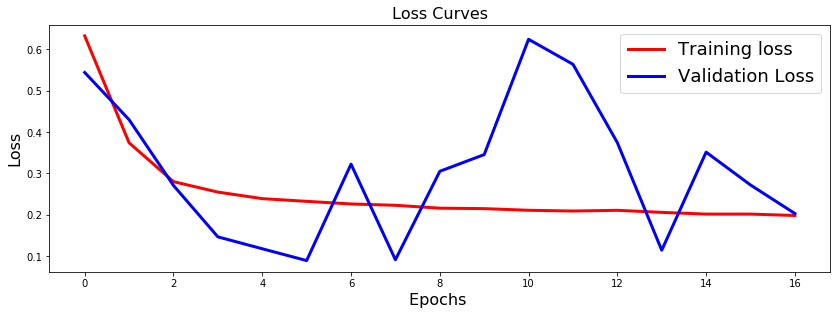

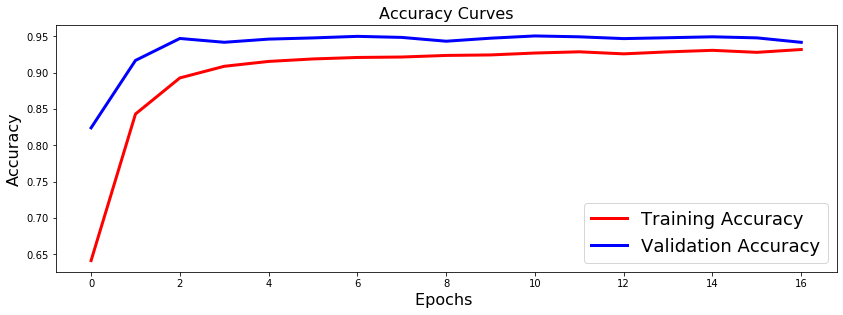

In [40]:
plt.figure(figsize=[14,10])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[14,10])
plt.subplot(212)
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [42]:
import numpy as np

test_image = image.load_img('/kaggle/input/files1/Malaria Cells/single_prediction/Parasitised.png', target_size = (100,100))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(train_generator.class_indices)
if result[0][0] == 1:
    prediction = 'Uninfected'
else:
    prediction = 'Parasitised'
print(prediction)

{'Parasitized': 0, 'Uninfected': 1}
Uninfected
